In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [11]:
df = pd.read_csv("flight_data_kiwi_allsnaps_clean.csv")

In [12]:
df_filtered = df[df["Dep Company"] == df["Back Company"]].copy()
df_filtered["Company"] = df_filtered["Dep Company"]

In [13]:
def parse_price_string(s):

    if not isinstance(s, str):
        return np.nan
    
    # הסרה של כל התווים שאינם ספרה, נקודה או מינוס, והחלפת '₪' וכו'
    # אפשרות פשוטה היא לפצל על רווחים ולנסות להמיר כל חלק
    parts = s.replace('₪','').split()
    
    floats = []
    for p in parts:
        # מחק כל סימן שאינו ספרה/נקודה/מינוס
        p_clean = re.sub(r'[^0-9\.-]+', '', p)
        if p_clean:
            try:
                val = float(p_clean)
                floats.append(val)
            except ValueError:
                pass
    
    if len(floats) == 0:
        return np.nan
    else:
        # נניח שנחזיר את האחרון
        return floats[-1]

# כעת החלת הפונקציה על עמודת Price
df['Price'] = df['Price'].apply(parse_price_string)

# בדיקת כמות ה-NaN שנוצרו
print("Number of NaN after parse:", df['Price'].isna().sum())
# Re-apply the parsing function on the filtered dataframe
df_filtered["Price"] = df_filtered["Price"].apply(parse_price_string)


Number of NaN after parse: 0


In [14]:

df_filtered["Dep Date"] = pd.to_datetime(df_filtered["Dep Date"])
df_filtered["Return Date"] = pd.to_datetime(df_filtered["Return Date"])
df_filtered["Snap Date"] = pd.to_datetime(df_filtered["Snap Date"])


In [15]:
def build_company_features(df_in):
    """
    For each Company, create features based ONLY on overall price stats.
    (No TTT or LOS usage.)
    """
    # Price mean & std overall
    agg_overall = df_in.groupby("Company").agg(
        price_mean_overall=("Price", "mean"),
        price_std_overall=("Price", "std")
    ).reset_index()

    return agg_overall

df_company_features = build_company_features(df_filtered)


In [16]:
company_cols = df_company_features.columns.drop("Company")
X_companies = df_company_features[company_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_companies)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_company_features["cluster"] = labels



c:\Users\orian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


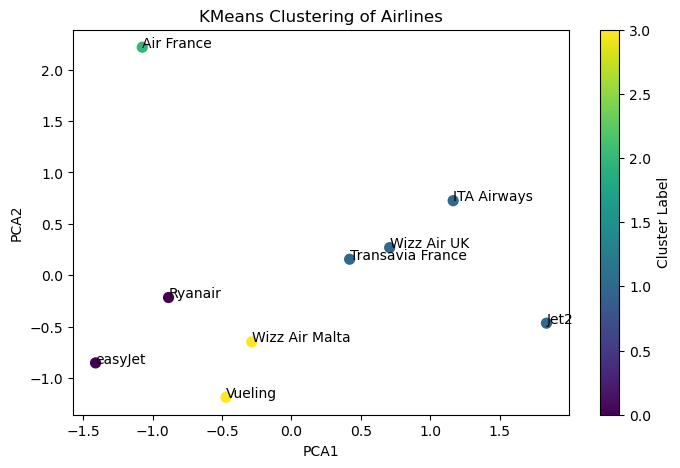

In [17]:
pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.scatter(coords_2d[:,0], coords_2d[:,1], c=labels, cmap='viridis', s=50)
for i, txt in enumerate(df_company_features["Company"]):
    plt.annotate(txt, (coords_2d[i,0], coords_2d[i,1]))

plt.title("KMeans Clustering of Airlines")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(label="Cluster Label")
plt.show()

Conclusions
* Air France is in a separate cluster, likely because it is a premium airline with higher ticket prices and additional services.
* Ryanair and easyJet are in the same cluster, confirming that they are well-defined low-cost carriers.
* Wizz Air Malta and Vueling are in a different cluster, possibly indicating a slightly different business model or service offering compared to other low-cost airlines.
* Jet2 and Wizz Air UK are grouped together, which may suggest similar pricing strategies or operational models.

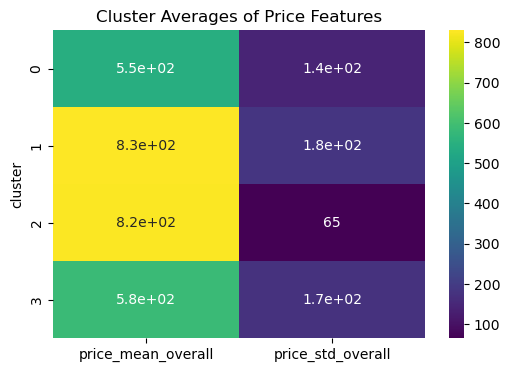


===== Clustering Results =====
            Company  price_mean_overall  price_std_overall  cluster
0        Air France          824.620000          65.080957        2
1       ITA Airways          898.251534         170.515531        1
2              Jet2          847.161470         223.157902        1
3           Ryanair          603.553044         139.188643        0
4  Transavia France          768.716957         165.530776        1
5           Vueling          548.836459         178.276914        3
6    Wizz Air Malta          620.079167         168.295551        3
7       Wizz Air UK          808.216157         170.497673        1
8           easyJet          489.151918         142.300114        0


In [18]:
df_for_heatmap = df_company_features.groupby("cluster").mean(numeric_only=True)
 # average price stats in each cluster

import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(df_for_heatmap, annot=True, cmap="viridis")
plt.title("Cluster Averages of Price Features")
plt.show()

print("\n===== Clustering Results =====")
print(df_company_features)

**Key Conclusions**  
* **Clusters 1 and 2 have the highest prices**, but **Cluster 2 is more stable in terms of pricing**.  
* **Clusters 0 and 3 are the cheapest**, but still show some price variation.  
* **If price stability is a priority, flights in Cluster 2 are preferable**.  
* **If looking for the cheapest flights, Clusters 0 or 3 are likely Low-Cost flights**.

Conclusions from the Clustering Analysis
* ITA Airways and Jet2 are the most expensive, but with high price variability.
* Air France is expensive but stable in its pricing (low standard deviation).
* Ryanair and easyJet are the cheapest, confirming their Low-Cost status.
* Wizz Air Malta has relatively low prices but high variability, indicating a flexible pricing structure.

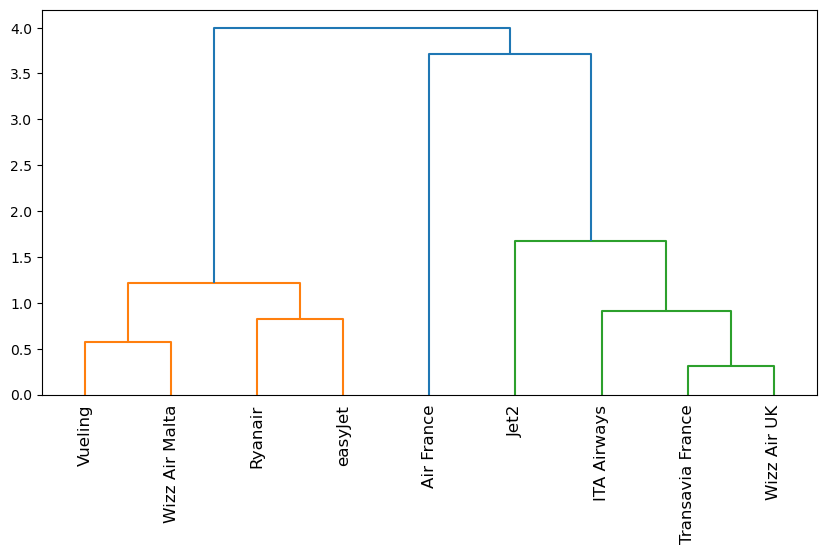

In [19]:
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(Z, labels=df_company_features["Company"].values, leaf_rotation=90)
plt.show()

### Key Analysis of Airline Groups

- **Low-Cost Airlines (Orange Cluster):**  
  **Ryanair, easyJet, Wizz Air Malta, and Vueling** are closely grouped, confirming their similar low-cost pricing model.  

- **Premium Airlines (Green Cluster):**  
  **ITA Airways, Transavia France, and Wizz Air UK** are in the same cluster, indicating similar services or pricing ranges.  

- **Air France Stands Alone:**  
  It is completely separate, suggesting significantly different pricing or service levels, likely more premium and stable.  

- **Jet2 and ITA Airways:**  
  Jet2 is grouped with ITA Airways, implying similar pricing strategies.  

In [20]:
print("\n===== Clustering Results =====")
print(df_company_features[["Company","cluster"] + list(company_cols)])


===== Clustering Results =====
            Company  cluster  price_mean_overall  price_std_overall
0        Air France        2          824.620000          65.080957
1       ITA Airways        1          898.251534         170.515531
2              Jet2        1          847.161470         223.157902
3           Ryanair        0          603.553044         139.188643
4  Transavia France        1          768.716957         165.530776
5           Vueling        3          548.836459         178.276914
6    Wizz Air Malta        3          620.079167         168.295551
7       Wizz Air UK        1          808.216157         170.497673
8           easyJet        0          489.151918         142.300114
